In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!kaggle datasets download iamsouravbanerjee/animal-image-dataset-90-different-animals

100% 653M/656M [00:17<00:00, 41.8MB/s]
100% 656M/656M [00:17<00:00, 39.6MB/s]


In [ ]:
!unzip /content/animal-image-dataset-90-different-animals.zip

Streaming output truncated to the last 5000 lines.
  inflating: animals/animals/bison/73b10839bc.jpg  
  inflating: animals/animals/bison/74dc1dd32a.jpg  
  inflating: animals/animals/bison/75ab166a7d.jpg  
  inflating: animals/animals/bison/79e1610d01.jpg  
  inflating: animals/animals/bison/7ba5eee91f.jpg  
  inflating: animals/animals/bison/7d214aab4b.jpg  
  inflating: animals/animals/bison/7f2ef9ab03.jpg  
  inflating: animals/animals/bison/82ec723a4f.jpg  
  inflating: animals/animals/bison/85e145af6c.jpg  
  inflating: animals/animals/bison/862e2c6379.jpg  
  inflating: animals/animals/bison/87a5c700ad.jpg  
  inflating: animals/animals/bison/88b723ce90.jpg  
  inflating: animals/animals/bison/8c3af742c3.jpg  
  inflating: animals/animals/bison/8e34044b98.jpg  
  inflating: animals/animals/bison/8e6adbdc40.jpg  
  inflating: animals/animals/bison/8fce80d5ba.jpg  
  inflating: animals/animals/bison/961a895686.jpg  
  inflating: animals/animals/bison/984a5b583d.jpg  
  inflating: 

In [ ]:
import numpy as np
from matplotlib import pyplot as plt, image as mpimg
import seaborn as sns

import torch
from torch.utils.data import Dataset
from torchvision import transforms
from torch import nn, optim
from torch.optim import lr_scheduler
from torchvision import models
from sklearn import preprocessing

import os
import time
import copy
from tqdm.notebook import trange, tqdm

In [ ]:
path = '/content/animals/animals/'

classes = os.listdir(path)

# View classes
num_classes = len(classes)
print(f'Number of classes: {num_classes}')
print(f'Classes of animals: {", ".join(classes)}')

Number of classes: 90
Classes of animals: woodpecker, fly, cockroach, owl, lobster, hippopotamus, swan, raccoon, sheep, pigeon, wolf, possum, otter, jellyfish, antelope, fox, dragonfly, bison, hyena, hare, dog, hornbill, koala, starfish, sparrow, bear, eagle, gorilla, hedgehog, wombat, goldfish, duck, rhinoceros, mouse, bat, leopard, flamingo, crow, reindeer, seahorse, coyote, lion, deer, bee, rat, mosquito, caterpillar, butterfly, crab, grasshopper, okapi, cat, sandpiper, dolphin, turtle, ox, elephant, snake, panda, hamster, boar, hummingbird, octopus, chimpanzee, penguin, goat, squid, parrot, whale, seal, pig, turkey, horse, tiger, goose, oyster, pelecaniformes, cow, donkey, lizard, ladybugs, zebra, moth, squirrel, shark, badger, porcupine, kangaroo, beetle, orangutan


In [ ]:
# See the number of images for each class
for animal in classes:
    print(f'Number of {animal} images: {len(os.listdir(path + animal))}')

Number of woodpecker images: 60
Number of fly images: 60
Number of cockroach images: 60
Number of owl images: 60
Number of lobster images: 60
Number of hippopotamus images: 60
Number of swan images: 60
Number of raccoon images: 60
Number of sheep images: 60
Number of pigeon images: 60
Number of wolf images: 60
Number of possum images: 60
Number of otter images: 60
Number of jellyfish images: 60
Number of antelope images: 60
Number of fox images: 60
Number of dragonfly images: 60
Number of bison images: 60
Number of hyena images: 60
Number of hare images: 60
Number of dog images: 60
Number of hornbill images: 60
Number of koala images: 60
Number of starfish images: 60
Number of sparrow images: 60
Number of bear images: 60
Number of eagle images: 60
Number of gorilla images: 60
Number of hedgehog images: 60
Number of wombat images: 60
Number of goldfish images: 60
Number of duck images: 60
Number of rhinoceros images: 60
Number of mouse images: 60
Number of bat images: 60
Number of leopa

#Creating silhouette dataset

In [ ]:
import shutil
shutil.rmtree('/content/Masks/')

In [ ]:
os.mkdir('/content/Masks/')
maskpath = '/content/Masks/'

In [ ]:
from google.colab.patches import cv2_imshow
import cv2

for animal in classes:
  os.mkdir(maskpath + animal + "/")
  images = os.listdir(path + animal)

  for img in images:
    g = cv2.imread(path + animal + "/" + img, 0)
    b = cv2.medianBlur(g, 5)
    b = cv2.GaussianBlur(b, (5, 5), 1.0)
    _, binary_mask = cv2.threshold(b, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, (11, 11))
    
    cv2.imwrite(maskpath + animal + "/" + img, binary_mask)


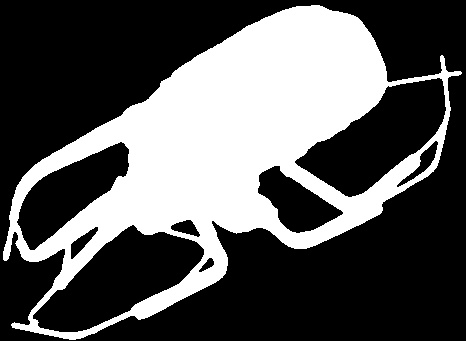

In [ ]:
i = cv2.imread('/content/Masks/beetle/4cb4b45e31.jpg')
cv2_imshow(i)

### Split data 

In [ ]:
def shuffle_data(X, seed):
    if seed:
        np.random.seed(seed)

    idx = np.arange(len(X))
    np.random.shuffle(idx)
    
    return np.array(X)[idx]
    
    
def data_split(maskpath, split_size=0.1):
    """
        Based on split size, 
        Each folder is split into training and test sets.

        Returns:
            Shuffled training, validation and test dataset
            Each set is in the form of: ['id.jpg', 'string label of id']
                Example: [['1234.jpg', 'antelope'], ['12312.jpg', 'iguana'] ...]
    """
    
    X_train, X_val, X_test = [], [], []
    y_train, y_val, y_test = [], [], []
    
    # For each label
    for animal in classes:
        
        # Extract same label for training, validation, test data
        label = animal
        
        # Image path for each animal
        image_list = os.listdir(maskpath + animal)
        
        # Shuffle images (path) 
        shuffled_data = shuffle_data(image_list, seed=None)
        
        # Get the train, val, test split
        split_i = len(shuffled_data) - int(len(shuffled_data) // (1 / (split_size * 2)))
        split_j = len(shuffled_data) - int(len(shuffled_data) // (1 / split_size)) 
        
        # Get training data from train_val_data split[:split_j]
        train_data = shuffled_data[:split_i]
        
        # Add training data, label to final training data
        X_train.extend(train_data) 
        y_train.extend([label] * len(train_data)) 
        
        # Get val data and label from train_val_data split[split_j:]
        val_data = shuffled_data[split_i:split_j]
        
        # Add val data, label to final val data
        X_val.extend(val_data) 
        y_val.extend([label] * len(val_data)) 
        
        # Get test data from shuffled_data[split_i:]
        test_data = shuffled_data[split_j:]
       
        # Add test data, label to final val data
        X_test.extend(test_data) 
        y_test.extend([label] * len(test_data)) 
    
    
    # Each image is presented as: ['image id.jpg', 'string label']
    training_data = list(zip(X_train, y_train))
    val_data = list(zip(X_val, y_val))
    test_data = list(zip(X_test, y_test))
    
    #Shuffle all data in respective sets
    shuffled_training_data = shuffle_data(training_data, seed=None)
    shuffled_val_data = shuffle_data(val_data, seed=None)
    shuffled_test_data = shuffle_data(test_data, seed=None)
    
    return shuffled_training_data, shuffled_val_data, shuffled_test_data

In [ ]:
# Split size for training, validation, test
split_size = 0.08

train_data, val_data, test_data = data_split(maskpath, split_size=split_size)
print('Number of training images: {}'.format(len(train_data)))
print('Number of validation images: {}'.format(len(val_data))) 
print('Number of testing images: {}'.format(len(test_data)))

Number of training images: 4590
Number of validation images: 450
Number of testing images: 360


In [ ]:
def image_plot(data):
    fig = plt.figure(figsize=(20, 6))
    rows = 3
    columns = 10

    ax = []

    # See the first 30 images
    for i in range(30):
        image, label = data[i]
        
        ax.append(fig.add_subplot(rows, columns, i+1))
        
        if torch.is_tensor(image):
            image = image.permute(1, 2, 0)
            ax[-1].set_title(le.inverse_transform([label])[0], fontsize=12, fontweight='bold')
        else:
            image_path =  os.path.join(maskpath + label + "/" + image)
            image = mpimg.imread(image_path)
            ax[-1].set_title(label, fontsize=12, fontweight='bold')
        
        if image.shape[0] == 256:
          image = image.reshape(256, -1)
        elif image.shape[1] == 256:
          image = image.reshape(-1, 256)
        plt.imshow(image, cmap='gray')
        plt.axis('off')

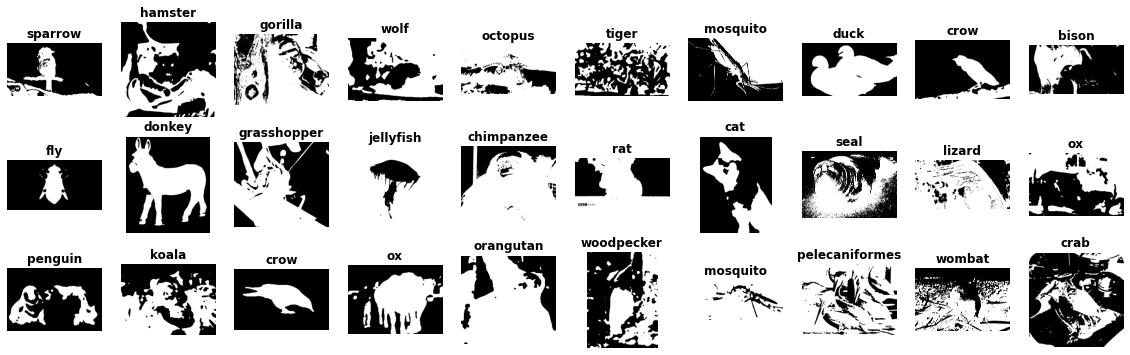

In [ ]:
# See some of the training images before pre-processing
image_plot(train_data)

### Dataset preparation and Label Encoding

In [ ]:
# To convert string labels into integers
le = preprocessing.LabelEncoder()
le.fit(classes)

LabelEncoder()

In [ ]:
class _Dataset(Dataset):
    
    def __init__(self, data, transform=None):
        data, label = zip(*data)
        
        # Transform string labels into integers
        label = le.transform(label)
        
        self.x = np.array(data)
        self.y = np.array(label)
        self.num_samples = len(data)
        self.transform = transform
        
    def __getitem__(self, index):
        sample = self.x[index], self.y[index]
        img_path = os.path.join(maskpath, le.inverse_transform([sample[1]])[0], sample[0])
        img = mpimg.imread(img_path)
        
        if self.transform:
            
            features = self.transform(img)
        
        return features, sample[1]
    
    def __len__(self):
        return self.num_samples
    
data_transforms = {
    'train': transforms.Compose(
        [transforms.ToPILImage(),
         transforms.Resize((256, 256)),
         transforms.RandomHorizontalFlip(),
         transforms.RandomRotation(15),
         transforms.ToTensor(),
         transforms.Normalize([0.5], [0.5])
        ]),
    'val': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
}


In [ ]:
training_dataset = _Dataset(train_data, transform=data_transforms['train'])
validation_dataset = _Dataset(val_data, transform=data_transforms['val'])
test_dataset = _Dataset(test_data, transform=data_transforms['val'])

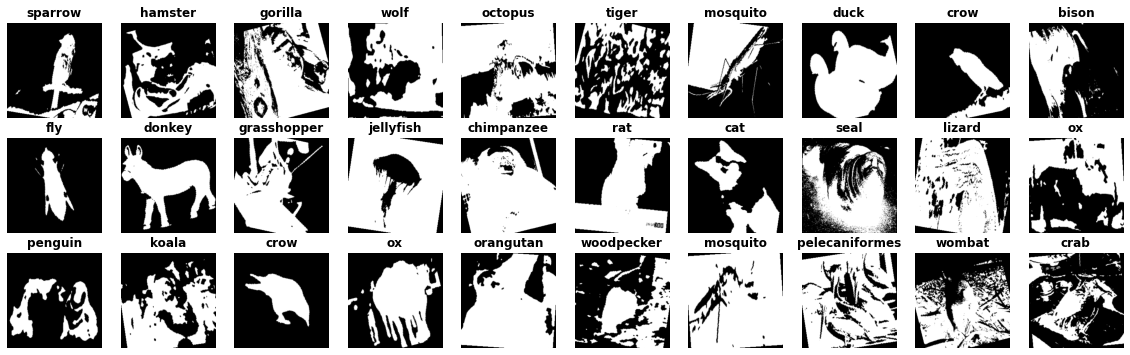

In [ ]:
# Visualise augmented ugly images
image_plot(training_dataset)

In [ ]:
batchsize = 64

train_loader = torch.utils.data.DataLoader(dataset=training_dataset, shuffle=True, batch_size=batchsize)
val_loader = torch.utils.data.DataLoader(dataset=validation_dataset, shuffle=False, batch_size=batchsize)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, shuffle=False, batch_size=batchsize)

### Model

In [ ]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
        
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            if self.counter > 0:
                print(f"Early stopping counter resetting from {self.counter} to 0.")
                self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.LeakyReLU(0.1, inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                     padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [ ]:
def _make_layer(block, inplanes,planes, blocks, stride=1):
    downsample = None  
    if stride != 1 or inplanes != planes:
        downsample = nn.Sequential(            
            nn.Conv2d(inplanes, planes, 1, stride, bias=False),
            nn.BatchNorm2d(planes),
        )
    layers = []
    layers.append(block(inplanes, planes, stride, downsample))
    inplanes = planes
    for _ in range(1, blocks):
        layers.append(block(inplanes, planes))
    return nn.Sequential(*layers)

In [ ]:
class NeuralNet(nn.Module):
    def __init__(self, block, layers, num_classes=90):
        super().__init__()
        
        self.inplanes = 64

        self.conv1 = nn.Conv2d(1, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.LeakyReLU(0.1, inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 , num_classes)


    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None  
   
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, 1, stride, bias=False),
                nn.BatchNorm2d(planes),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        
        self.inplanes = planes
        
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)         # 1x1
        x = torch.flatten(x, 1)     # remove 1 X 1 grid and make vector of tensor shape 
        x = self.fc(x)

        return x
          

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

layers = [10, 10, 10, 10]
model = NeuralNet(BasicBlock, layers).to(device)

# Model Summary
print(model)

NeuralNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): LeakyReLU(negative_slope=0.1, inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.1, inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, scheduler=None, early_stopping=None):
    since = time.time()
    
    training_accuracies, training_losses, val_accuracies, val_losses = [], [], [], []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 60)
        
        # Each epoch has a training and validation phase
        for phase in ['Training', 'Validation']:
            if phase == 'Training':
                model.train()  # Set model to training mode
                dataloaders = train_loader
                dataset_sizes = len(training_dataset)
            else:
                model.eval()   # Set model to evaluate mode
                dataloaders = val_loader
                dataset_sizes = len(validation_dataset)

            running_loss = 0.0
            running_corrects = 0
     
            # Iterate over data.
            for inputs, labels in tqdm(dataloaders):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Training'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'Training':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'Training':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes
            epoch_acc = running_corrects.double() / dataset_sizes

            if phase == 'Training':
                training_accuracies.append(epoch_acc)
                training_losses.append(epoch_loss)
            else:
                val_accuracies.append(epoch_acc)
                val_losses.append(epoch_loss)

            # deep copy the model
            if phase == 'Validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            
            print('{} Loss after epoch: {:.4f}, Acc after epoch: {:.4f}\n'.format(
            phase, epoch_loss, epoch_acc))
            
        
        # Early stopping check with last average validation loss after end of epoch
        if early_stopping is not None:
            early_stopping(val_losses[-1])

            if early_stopping.early_stop:
                print('Early Stopping Initiated')
                break


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, training_accuracies, training_losses, val_accuracies, val_losses   

learning_rate=0.01

num_epochs=1000

criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer_ft = optim.Adam(model.parameters(), lr=learning_rate)

# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

# Early stopping if val_loss does not improve from the best - 1e-5 over next 5 epochs
es = EarlyStopping(patience=10, min_delta=1e-5)

In [ ]:
model_ft, training_accuracies, training_losses, val_accuracies, val_losses = train_model(model=model,
                                                                                         train_loader=train_loader,
                                                                                         val_loader=val_loader, 
                                                                                         criterion=criterion, 
                                                                                         optimizer=optimizer_ft, 
                                                                                         num_epochs=num_epochs, 
                                                                                         scheduler=exp_lr_scheduler, 
                                                                                         early_stopping=es)

Epoch 1/100
------------------------------------------------------------


  0%|          | 0/72 [00:00<?, ?it/s]

Training Loss after epoch: 5.6782, Acc after epoch: 0.0113



  0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss after epoch: 4.7224, Acc after epoch: 0.0178

Epoch 2/100
------------------------------------------------------------


  0%|          | 0/72 [00:00<?, ?it/s]

Training Loss after epoch: 4.4855, Acc after epoch: 0.0194



  0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss after epoch: 4.4810, Acc after epoch: 0.0178

Epoch 3/100
------------------------------------------------------------


  0%|          | 0/72 [00:00<?, ?it/s]

Training Loss after epoch: 4.4219, Acc after epoch: 0.0227



  0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss after epoch: 4.4284, Acc after epoch: 0.0222

Epoch 4/100
------------------------------------------------------------


  0%|          | 0/72 [00:00<?, ?it/s]

Training Loss after epoch: 4.3724, Acc after epoch: 0.0251



  0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss after epoch: 4.4015, Acc after epoch: 0.0311

Epoch 5/100
------------------------------------------------------------


  0%|          | 0/72 [00:00<?, ?it/s]

Training Loss after epoch: 4.3338, Acc after epoch: 0.0344



  0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss after epoch: 4.3864, Acc after epoch: 0.0444

Epoch 6/100
------------------------------------------------------------


  0%|          | 0/72 [00:00<?, ?it/s]

Training Loss after epoch: 4.3078, Acc after epoch: 0.0338



  0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss after epoch: 4.3985, Acc after epoch: 0.0333

Early stopping counter 1 of 5
Epoch 7/100
------------------------------------------------------------


  0%|          | 0/72 [00:00<?, ?it/s]

Training Loss after epoch: 4.2855, Acc after epoch: 0.0386



  0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss after epoch: 4.3779, Acc after epoch: 0.0378

Early stopping counter resetting from 1 to 0.
Epoch 8/100
------------------------------------------------------------


  0%|          | 0/72 [00:00<?, ?it/s]

Training Loss after epoch: 4.2643, Acc after epoch: 0.0460



  0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss after epoch: 4.3869, Acc after epoch: 0.0267

Early stopping counter 1 of 5
Epoch 9/100
------------------------------------------------------------


  0%|          | 0/72 [00:00<?, ?it/s]

Training Loss after epoch: 4.2338, Acc after epoch: 0.0488



  0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss after epoch: 4.4012, Acc after epoch: 0.0511

Early stopping counter 2 of 5
Epoch 10/100
------------------------------------------------------------


  0%|          | 0/72 [00:00<?, ?it/s]

Training Loss after epoch: 4.1928, Acc after epoch: 0.0569



  0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss after epoch: 4.3563, Acc after epoch: 0.0511

Early stopping counter resetting from 2 to 0.
Epoch 11/100
------------------------------------------------------------


  0%|          | 0/72 [00:00<?, ?it/s]

Training Loss after epoch: 4.1096, Acc after epoch: 0.0643



  0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss after epoch: 4.2748, Acc after epoch: 0.0667

Epoch 12/100
------------------------------------------------------------


  0%|          | 0/72 [00:00<?, ?it/s]

Training Loss after epoch: 4.0519, Acc after epoch: 0.0725



  0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss after epoch: 4.2824, Acc after epoch: 0.0578

Early stopping counter 1 of 5
Epoch 13/100
------------------------------------------------------------


  0%|          | 0/72 [00:00<?, ?it/s]

Training Loss after epoch: 4.0314, Acc after epoch: 0.0786



  0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss after epoch: 4.2627, Acc after epoch: 0.0578

Early stopping counter resetting from 1 to 0.
Epoch 14/100
------------------------------------------------------------


  0%|          | 0/72 [00:00<?, ?it/s]

Training Loss after epoch: 4.0139, Acc after epoch: 0.0786



  0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss after epoch: 4.2591, Acc after epoch: 0.0622

Epoch 15/100
------------------------------------------------------------


  0%|          | 0/72 [00:00<?, ?it/s]

Training Loss after epoch: 3.9829, Acc after epoch: 0.0839



  0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss after epoch: 4.2543, Acc after epoch: 0.0711

Epoch 16/100
------------------------------------------------------------


  0%|          | 0/72 [00:00<?, ?it/s]

Training Loss after epoch: 3.9752, Acc after epoch: 0.0882



  0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss after epoch: 4.2552, Acc after epoch: 0.0644

Early stopping counter 1 of 5
Epoch 17/100
------------------------------------------------------------


  0%|          | 0/72 [00:00<?, ?it/s]

Training Loss after epoch: 3.9434, Acc after epoch: 0.0943



  0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss after epoch: 4.2354, Acc after epoch: 0.0711

Early stopping counter resetting from 1 to 0.
Epoch 18/100
------------------------------------------------------------


  0%|          | 0/72 [00:00<?, ?it/s]

Training Loss after epoch: 3.9322, Acc after epoch: 0.0976



  0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss after epoch: 4.2093, Acc after epoch: 0.0844

Epoch 19/100
------------------------------------------------------------


  0%|          | 0/72 [00:00<?, ?it/s]

Training Loss after epoch: 3.9126, Acc after epoch: 0.0911



  0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss after epoch: 4.2442, Acc after epoch: 0.0622

Early stopping counter 1 of 5
Epoch 20/100
------------------------------------------------------------


  0%|          | 0/72 [00:00<?, ?it/s]

Training Loss after epoch: 3.8954, Acc after epoch: 0.1031



  0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss after epoch: 4.2214, Acc after epoch: 0.0689

Early stopping counter 2 of 5
Epoch 21/100
------------------------------------------------------------


  0%|          | 0/72 [00:00<?, ?it/s]

Training Loss after epoch: 3.8228, Acc after epoch: 0.1122



  0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss after epoch: 4.2075, Acc after epoch: 0.0756

Early stopping counter resetting from 2 to 0.
Epoch 22/100
------------------------------------------------------------


  0%|          | 0/72 [00:00<?, ?it/s]

Training Loss after epoch: 3.8098, Acc after epoch: 0.1133



  0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss after epoch: 4.2073, Acc after epoch: 0.0711

Epoch 23/100
------------------------------------------------------------


  0%|          | 0/72 [00:00<?, ?it/s]

Training Loss after epoch: 3.8001, Acc after epoch: 0.1159



  0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss after epoch: 4.2016, Acc after epoch: 0.0778

Epoch 24/100
------------------------------------------------------------


  0%|          | 0/72 [00:00<?, ?it/s]

Training Loss after epoch: 3.8051, Acc after epoch: 0.1170



  0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss after epoch: 4.2057, Acc after epoch: 0.0711

Early stopping counter 1 of 5
Epoch 25/100
------------------------------------------------------------


  0%|          | 0/72 [00:00<?, ?it/s]

Training Loss after epoch: 3.7853, Acc after epoch: 0.1183



  0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss after epoch: 4.2166, Acc after epoch: 0.0756

Early stopping counter 2 of 5
Epoch 26/100
------------------------------------------------------------


  0%|          | 0/72 [00:00<?, ?it/s]

Training Loss after epoch: 3.7841, Acc after epoch: 0.1185



  0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss after epoch: 4.2062, Acc after epoch: 0.0778

Early stopping counter 3 of 5
Epoch 27/100
------------------------------------------------------------


  0%|          | 0/72 [00:00<?, ?it/s]

Training Loss after epoch: 3.7821, Acc after epoch: 0.1146



  0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss after epoch: 4.2202, Acc after epoch: 0.0778

Early stopping counter 4 of 5
Epoch 28/100
------------------------------------------------------------


  0%|          | 0/72 [00:00<?, ?it/s]

Training Loss after epoch: 3.7725, Acc after epoch: 0.1261



  0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss after epoch: 4.2170, Acc after epoch: 0.0733

Early stopping counter 5 of 5
Early Stopping Initiated
Training complete in 42m 37s
Best val Acc: 0.084444


In [ ]:
torch.save(model, 'mask-classifier.pt')
torch.save(model, 'mask-classifier.pth')
torch.save(model.state_dict(), 'mask-classifier-sd.pt')
torch.save(model.state_dict(), 'mask-classifier-sd.pth')

### Training and Validation Plots

In [43]:
# Plots for accuracy and loss
def plot_history():
    with plt.style.context('seaborn-darkgrid'):
        fig = plt.figure(figsize=(25,10))

        # Summarize history for accuracy
        plt.subplot(1, 2, 1)
        tac = [t.cpu() for t in training_accuracies]
        vac = [v.cpu() for v in val_accuracies]
        plt.plot([*range(len(training_accuracies))], tac)
        plt.plot([*range(len(val_accuracies))], vac)
        plt.title('Accuracy ', fontsize=15)
        plt.ylabel('Accuracy', fontsize=15)
        plt.xlabel('Epoch', fontsize=15)
    #     plt.ylim([0.4, 1.0])
        plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper right', fontsize=15)

        # Summarize history for loss
        plt.subplot(1, 2, 2)
        plt.plot([*range(len(training_losses))], training_losses, label='training loss')
        plt.plot([*range(len(val_losses))], val_losses, label='validation loss')
        plt.title('Losses', fontsize=15)
        plt.ylabel('Loss', fontsize=15)
        plt.xlabel('Epoch', fontsize=15)
    #     plt.ylim([0.0, 1.5])
        plt.legend(['Training Loss', 'Validation Loss'], loc='upper right', fontsize=15)

        plt.show()


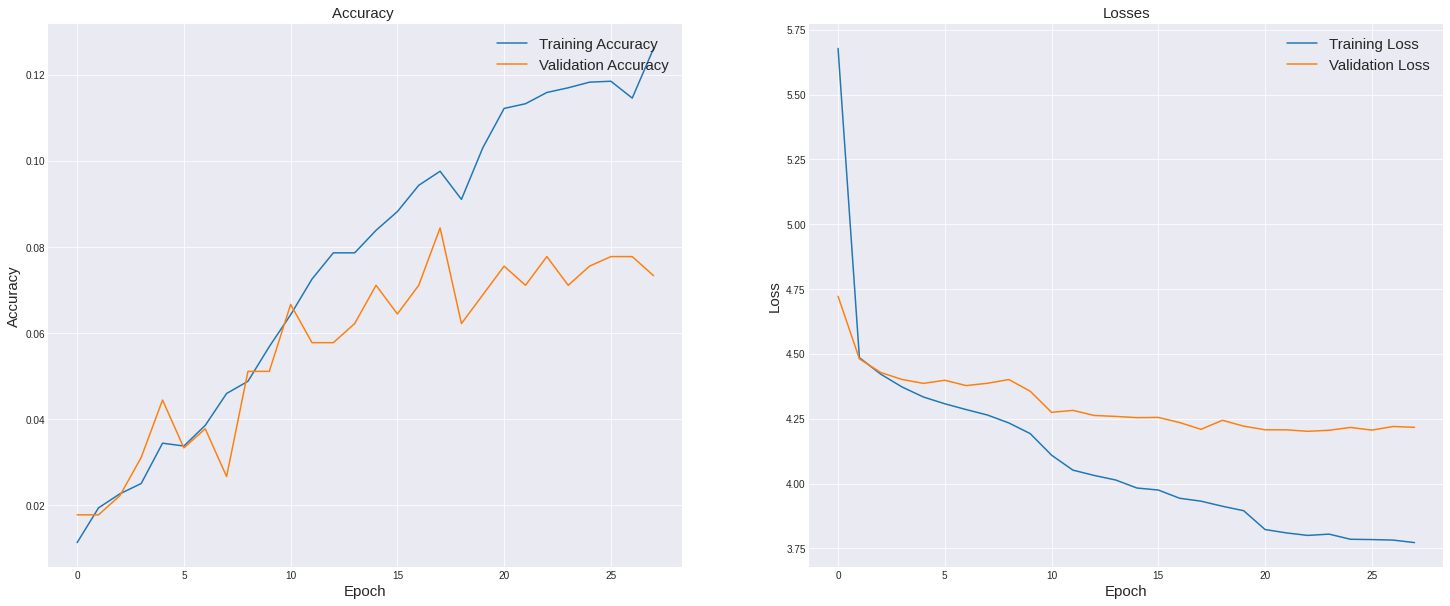

In [44]:
plot_history()

### Visualise model predictions

In [50]:
def visualize_model(model, data_loader, num_images=25):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(25, 30))
    
    fig.canvas.draw()
    
    rows = 5
    columns = 5
    
    MEAN = torch.tensor([0.5])
    STD = torch.tensor([0.5])
    
    with torch.no_grad():
            
        for i, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)

            outputs = model(inputs)
            val, preds = torch.max(outputs, 1)

            preds_invtrans = le.inverse_transform(preds.cpu())
            
            labels_invtrans = le.inverse_transform(labels.cpu())
            
            ax = []
            for j in range(inputs.size()[0]):
                images_so_far +=1
                ax.append(plt.subplot(rows, columns, images_so_far))

                # Reverse normalize 
                image = inputs.cpu().data[j] * STD[:, None, None] + MEAN[:, None, None]

                image = image.permute(1, 2, 0)

                ax[-1].set_title(f'Ground Truth: {labels_invtrans[j]}\nPredicted: {preds_invtrans[j]}', fontsize=15, fontweight='bold')
                
                # Draw boxes around subplots
                bbox = ax[-1].get_tightbbox(fig.canvas.renderer)
                x0, y0, width, height = bbox.transformed(fig.transFigure.inverted()).bounds
                
                # slightly increase the very tight bounds:
                xpad = 0.01 * width
                ypad = 0.01 * height
                
                if preds[j] == labels[j]:
                     fig.add_artist(plt.Rectangle((x0-xpad, y0-ypad), width+2*xpad, height+2*ypad, edgecolor='green', linewidth=5, fill=False))
                else:
                     fig.add_artist(plt.Rectangle((x0-xpad, y0-ypad), width+2*xpad, height+2*ypad, edgecolor='red', linewidth=5, fill=False))

                plt.imshow(image.reshape(256, 256), cmap='gray')
                plt.axis('off')

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return

        model.train(mode=was_training)
        

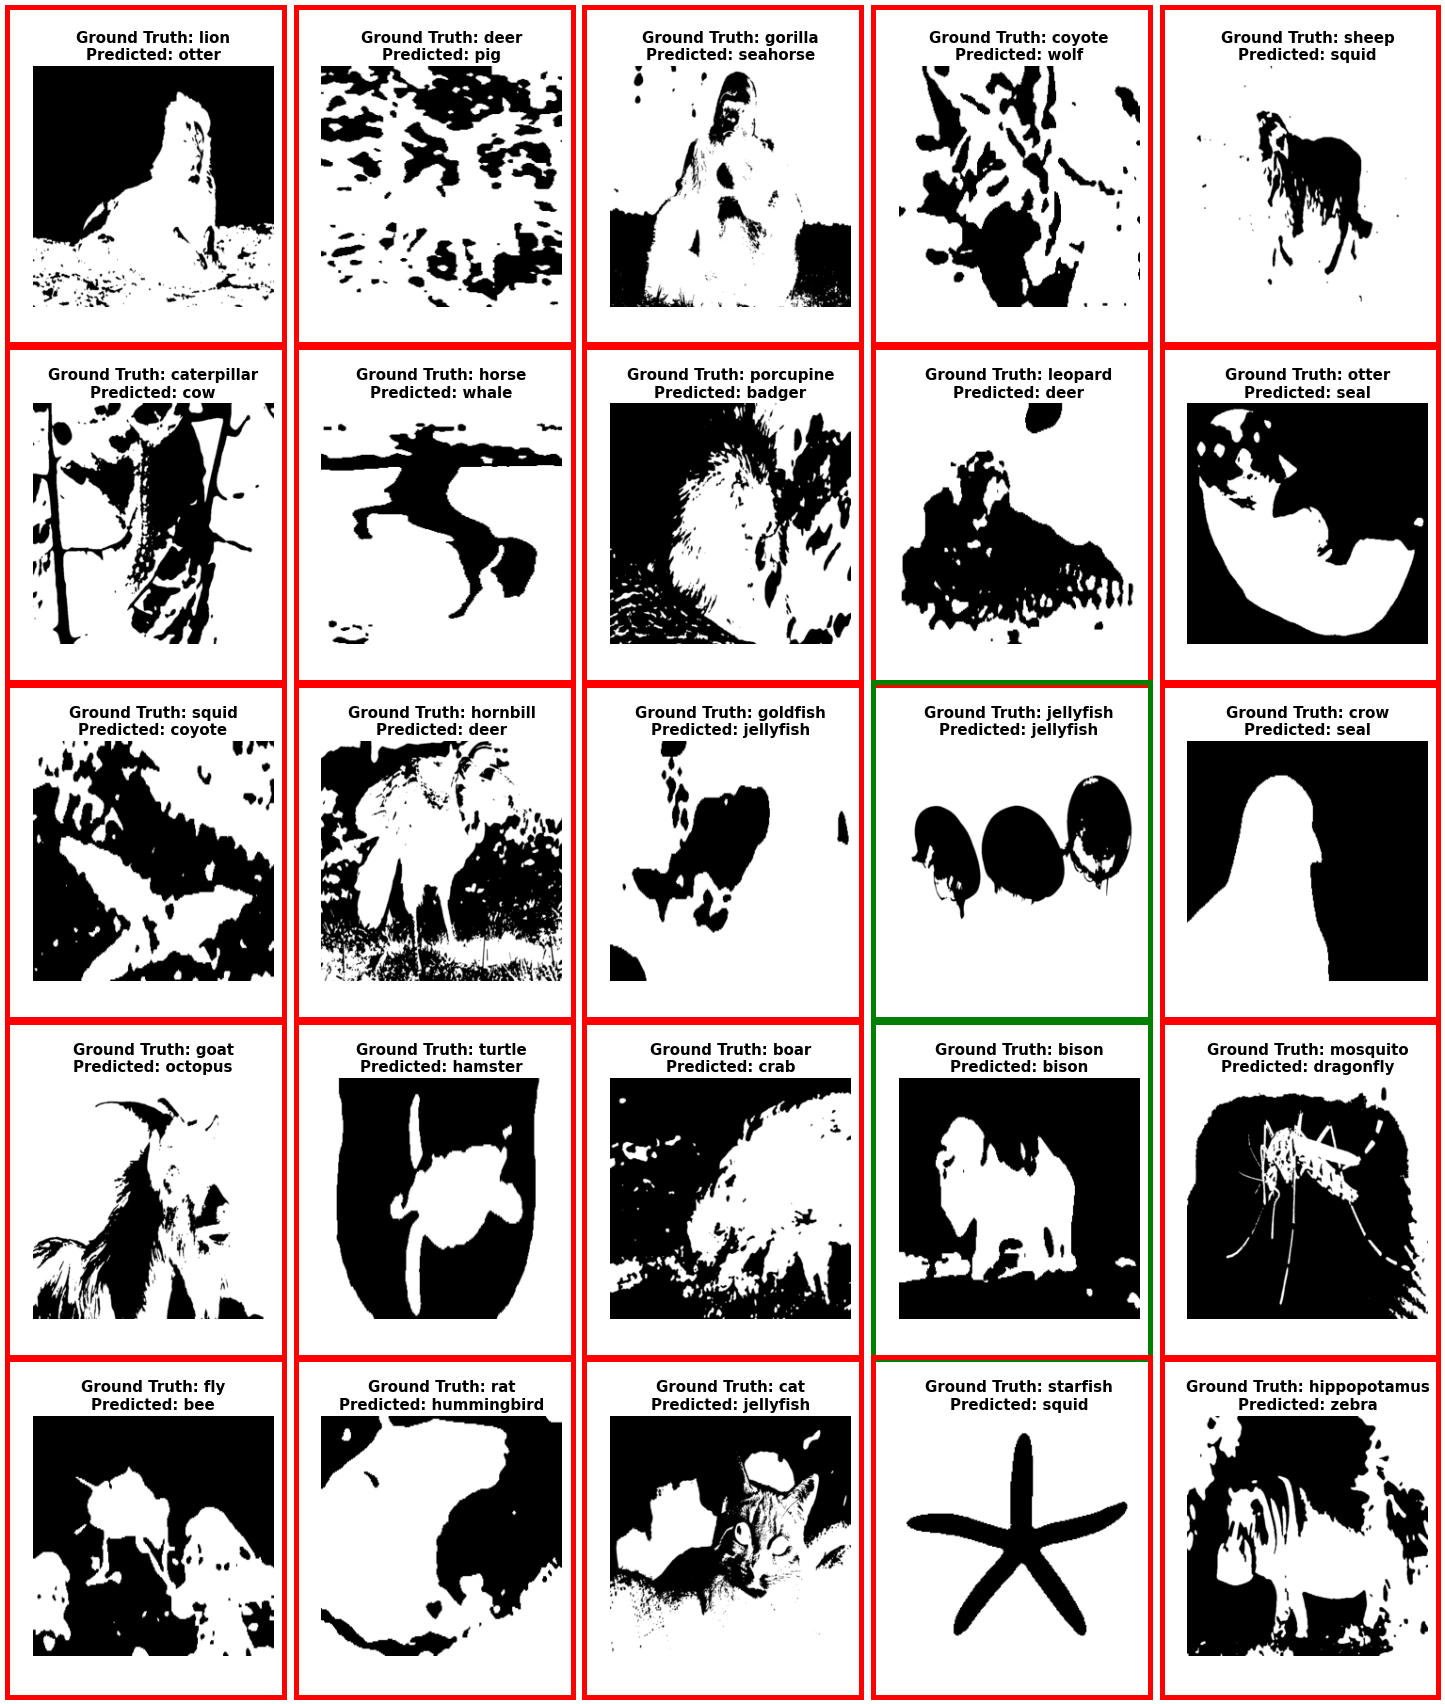

In [51]:
# Visualise on validation dataset
visualize_model(model_ft, val_loader)

### Test Set

In [52]:
labels_list = []
preds_list = []
with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        labels_list.extend(label.item() for label in labels)
        
        outputs = model_ft(inputs)
        
        predictions = torch.argmax(outputs, dim=1)
    
        preds_list.extend(prediction.item() for prediction in predictions)

        
count = 0
for i in range(len(preds_list)):
    if preds_list[i] == labels_list[i]:
        count += 1

accuracy = count / len(preds_list)
print(f'Test accuracy = {accuracy:.4f}')

  0%|          | 0/6 [00:00<?, ?it/s]

Test accuracy = 0.0639


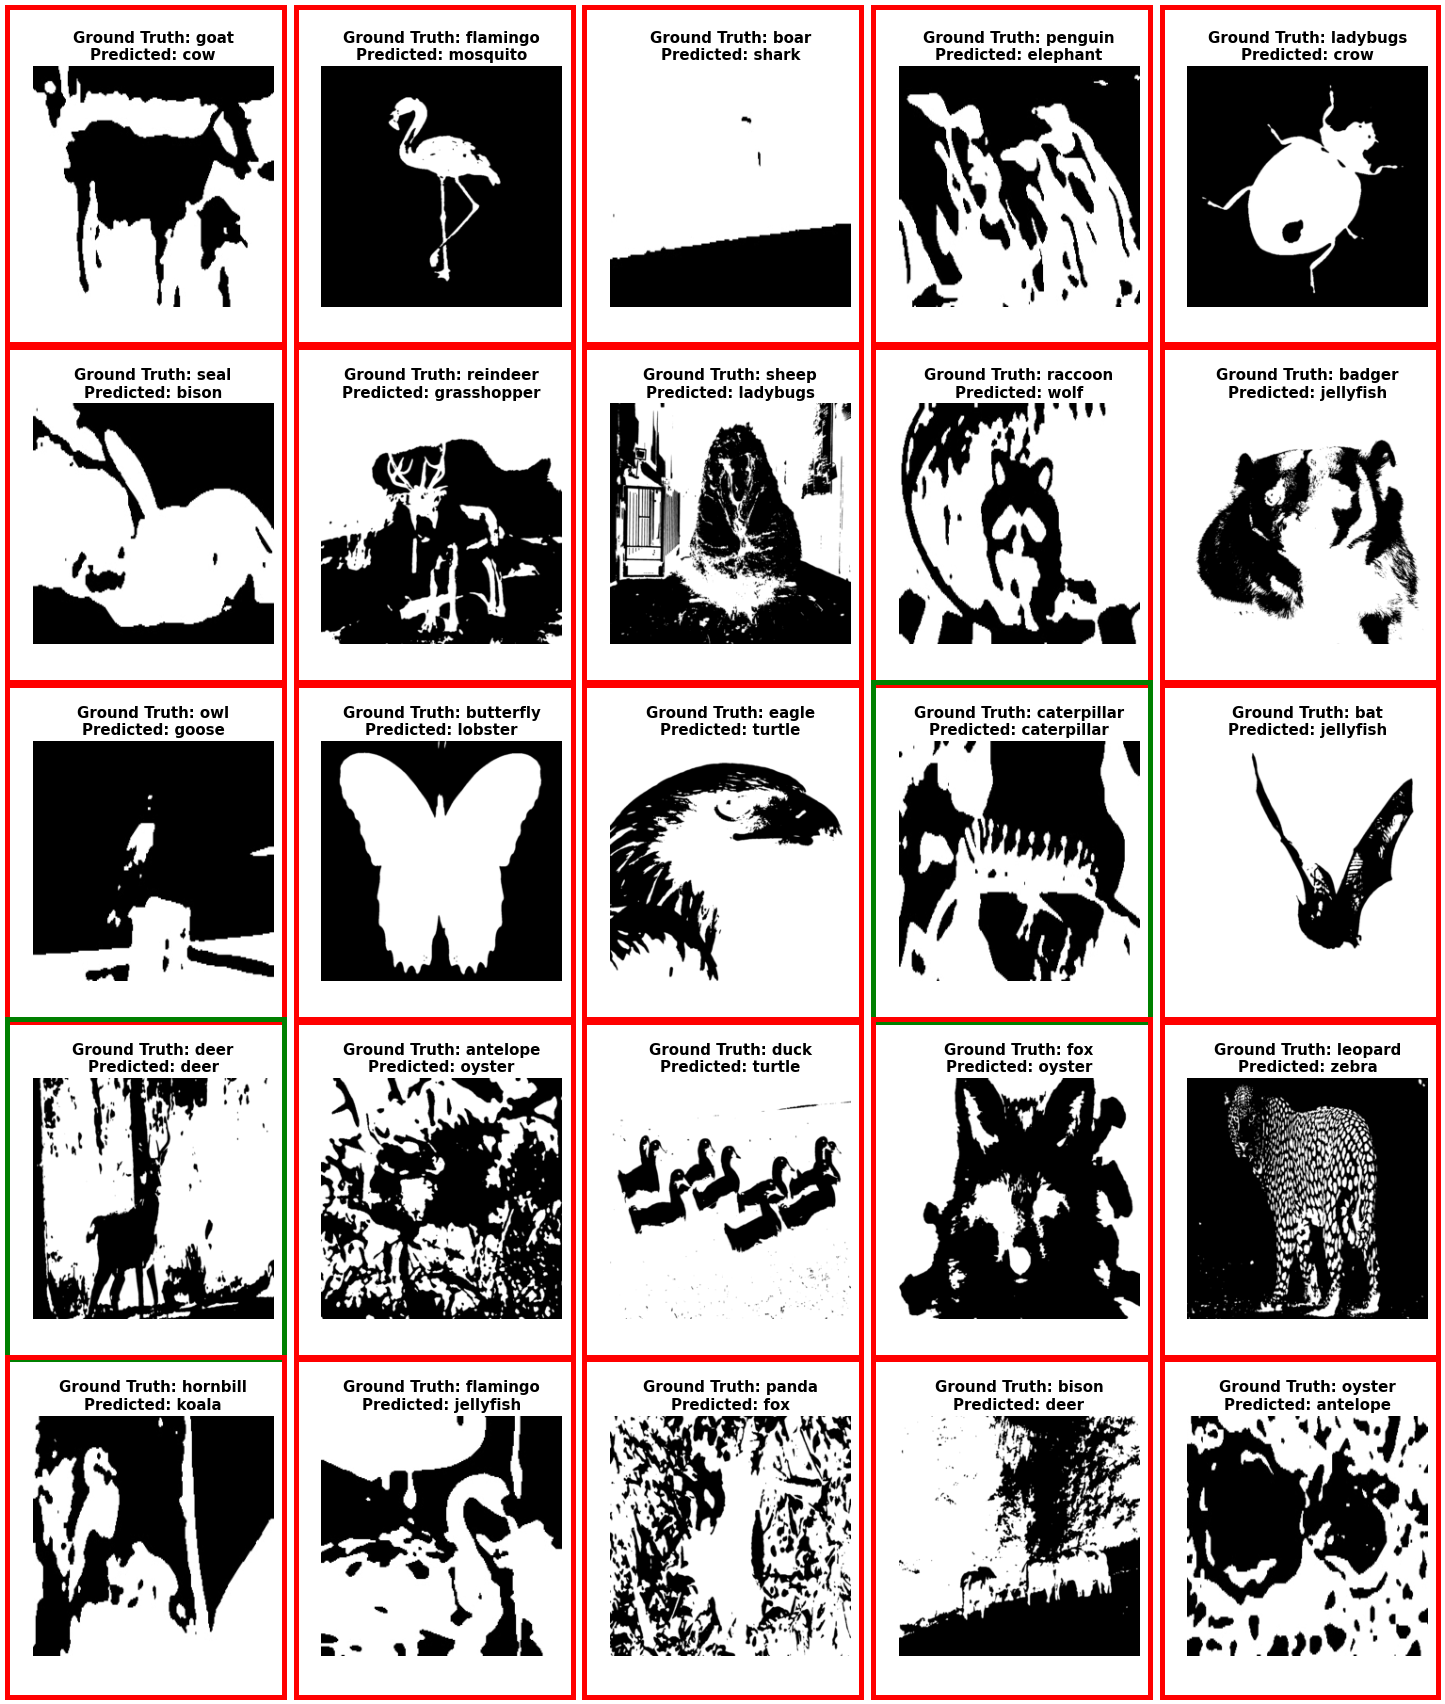

In [53]:
# Visualise predictions on test dataset
visualize_model(model_ft, test_loader)

In [54]:
from sklearn.metrics import classification_report

report = classification_report(labels_list, preds_list)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         4
           6       0.10      0.50      0.17         4
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         4
          10       0.50      0.25      0.33         4
          11       0.00      0.00      0.00         4
          12       0.23      0.75      0.35         4
          13       0.00      0.00      0.00         4
          14       0.10      0.25      0.14         4
          15       0.00      0.00      0.00         4
          16       0.07      0.25      0.11         4
          17       0.10    

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
